In [89]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import clip
from sklearn.preprocessing import StandardScaler
import hdbscan
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from IPython.display import display

In [1]:
# load data
excel_path = "C:/Users/megdy/Desktop/stat 4830/STAT-4830-vllm-project/two_tower/clothing_data.xlsx"
df = pd.read_excel(excel_path)

# If the first column is useless, drop it
df.drop(df.columns[0], axis=1, inplace=True)

df.head()


NameError: name 'pd' is not defined

In [91]:
#load clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


In [92]:
image_folder = "C:/Users/megdy/Desktop/stat 4830/STAT-4830-vllm-project/two_tower/dataset"
df["text_embedding"] = None
df["image_embedding"] = None

In [93]:
for idx, row in df.iterrows():
    # ----------------------------------
    # a) Find the corresponding image file
    # ----------------------------------
    # As per your description, for row i in df, 
    # the image file is named (i+2).jpg or (i+2).png
    image_number = idx + 2
    jpg_path = os.path.join(image_folder, f"{image_number}.jpg")
    png_path = os.path.join(image_folder, f"{image_number}.png")

    # Convert .jpg to .png if needed
    if os.path.isfile(jpg_path) and not os.path.isfile(png_path):
        try:
            img = Image.open(jpg_path).convert("RGB")
            img.save(png_path, "PNG")  # Save as PNG
            os.remove(jpg_path)  # Delete original JPG
            print(f"Converted {jpg_path} → {png_path}")
        except Exception as e:
            print(f"Error converting {jpg_path}: {e}")

    image_path = png_path if os.path.isfile(png_path) else None

    if not image_path:
        print(f"Warning: No image found for row {idx}, expected {image_number}.png")
        continue

    # ----------------------------------
    # b) Load text and image
    # ----------------------------------
    text_str = f"{row['brand']} {row['name']} {row['description']}"
    text_str = text_str[:77]

    # Load and preprocess the image
    raw_image = Image.open(image_path).convert("RGB")
    image_input = preprocess(raw_image).unsqueeze(0).to(device)

    # ----------------------------------
    # c) Encode text and image using CLIP
    # ----------------------------------
    with torch.no_grad():
        # Text encoding
        text_tokens = clip.tokenize([text_str]).to(device)  # batch with 1 item
        text_embeds = model.encode_text(text_tokens)
        # Image encoding
        image_embeds = model.encode_image(image_input)

    # Convert embeddings to CPU and then to list (or NumPy array) for easier storage
    text_embedding = text_embeds[0].cpu().numpy().tolist()
    image_embedding = image_embeds[0].cpu().numpy().tolist()

    # ----------------------------------
    # d) Insert embeddings into the DataFrame
    # ----------------------------------
    df.at[idx, "text_embedding"] = text_embedding
    df.at[idx, "image_embedding"] = image_embedding
    df.at[idx, "image_path"] = image_path

In [94]:
# Drops any row where at least one column is NaN/None
df = df.dropna(axis="index", how="any")

In [95]:
text_embs = np.array(df["text_embedding"].to_list())  # (n, 512)
img_embs  = np.array(df["image_embedding"].to_list()) # (n, 512)

# Scale price
scaler = StandardScaler()
price_scaled = scaler.fit_transform(df[["price"]])  # shape (n, 1)

# Combine features => shape (n, 1025)
features = np.hstack([text_embs, img_embs, price_scaled])


In [96]:
# Create the HDBSCAN model. 
# You can tune 'min_cluster_size' to control how large a cluster must be 
# to be considered valid. 
# 'min_samples' can help control outlier sensitivity.

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,  # e.g. each cluster must have at least 10 points
    min_samples=1,        # adjusts how strictly points are judged as outliers
    metric='euclidean'
)

# Fit and predict cluster labels
cluster_labels = clusterer.fit_predict(features)

# Add them to the DataFrame
df["cluster"] = cluster_labels

# HDBSCAN may label some points as -1 if they are outliers/noise
df["image_path"] = [
    (Path(image_folder) / f"{i+2}.png").as_posix()
    for i in df.index
]


In [97]:
unique_clusters = np.unique(cluster_labels)
print("Clusters found:", unique_clusters)  # e.g. [0, 1, 2, 3, -1]


Clusters found: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [98]:
# from IPython.display import display, Image

# unique_clusters = sorted(df["cluster"].unique())

# for label in unique_clusters:
#     cluster_df = df[df["cluster"] == label]
    
#     print(f"=== Cluster {label} === (Total items: {len(cluster_df)})")
    
#     # Show just a few images from this cluster
#     for _, row in cluster_df.head(5).iterrows():
#         img_path = row["image_path"]
#         if os.path.isfile(img_path):
#             display(Image(filename=img_path, width=200))
#         else:
#             print(f"Image not found: {img_path}")
    
#     print()  # blank line

In [99]:
class TwoTowerModel(nn.Module):
    def __init__(self, embedding_dim=1025):
        super(TwoTowerModel, self).__init__()
        self.user_tower = nn.Sequential(nn.Linear(embedding_dim, 512), nn.ReLU(),
                                        nn.Linear(512, 256), nn.ReLU(),
                                        nn.Linear(256, 128))
        self.item_tower = nn.Sequential(nn.Linear(embedding_dim, 512), nn.ReLU(),
                                        nn.Linear(512, 256), nn.ReLU(),
                                        nn.Linear(256, 128))

    def forward(self, user_emb, item_emb):
        user_repr = self.user_tower(user_emb)
        item_repr = self.item_tower(item_emb)
        return torch.cosine_similarity(user_repr, item_repr, dim=1)


In [100]:
user_item_dict = df.groupby("user")["name"].apply(list).to_dict()
item_embeddings = torch.tensor(features, dtype=torch.float32)

user_embeddings = {}
for user, items in user_item_dict.items():
    item_indices = df[df["name"].isin(items)].index.tolist()
    if len(item_indices) > 0:
        user_embs = item_embeddings[item_indices].mean(dim=0)
        user_embeddings[user] = user_embs

user_embeddings_tensor = torch.stack(list(user_embeddings.values()))


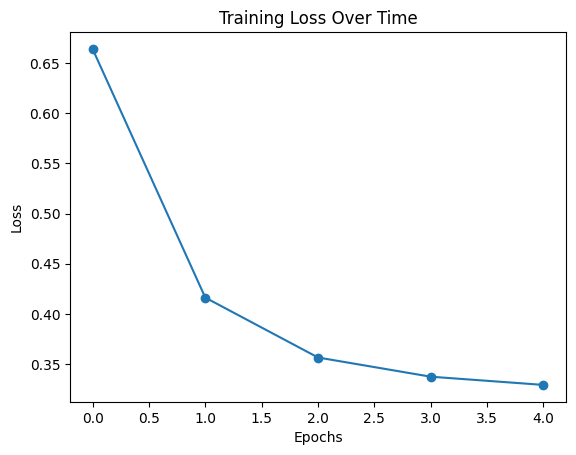

In [101]:
dataset = [(user_embeddings[user], item_embeddings[np.random.choice(len(df))])
           for user in user_item_dict]
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = TwoTowerModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

losses = []
for epoch in range(5):
    epoch_loss = 0
    for user_emb, pos_item_emb in dataloader:
        optimizer.zero_grad()
        sim = model(user_emb, pos_item_emb)
        labels = torch.ones_like(sim)
        loss = loss_fn(sim, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(dataloader))

# Plot Training Loss
plt.plot(losses, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()


In [102]:
def recommend_items(user_id, top_k=5):
    if user_id not in user_embeddings:
        print(f"User {user_id} not found!")
        return None
    user_emb = user_embeddings[user_id].unsqueeze(0)
    user_repr = model.user_tower(user_emb)
    item_reprs = model.item_tower(item_embeddings)
    scores = torch.cosine_similarity(user_repr, item_reprs, dim=1)
    return df.iloc[scores.argsort(descending=True)[:top_k].cpu().numpy()][["brand", "name", "image_path"]]


In [103]:
def show_recommendations(user_id, top_k=5):
    recommendations = recommend_items(user_id, top_k)
    
    if recommendations is None:
        return
    
    print(f"\n🔹 Top-{top_k} Recommendations for User: {user_id}\n")
    
    fig, axes = plt.subplots(1, top_k, figsize=(15, 5))
    for i, (_, row) in enumerate(recommendations.iterrows()):
        img_path = row["image_path"]
        
        if os.path.isfile(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{row['brand']}\n{row['name']}", fontsize=10)
            axes[i].axis("off")
        else:
            axes[i].set_title("Image Not Found", fontsize=10)
            axes[i].axis("off")

    plt.show()

def visualize_embeddings():
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_embeddings = tsne.fit_transform(features)
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df["cluster"], cmap="tab20", alpha=0.7)
    plt.colorbar(label="Cluster")
    plt.title("t-SNE Visualization of Item Embeddings")
    plt.show()

def plot_cluster_distribution():
    sns.barplot(x=df["cluster"].value_counts().index, y=df["cluster"].value_counts().values, palette="viridis")
    plt.title("Cluster Distribution")
    plt.show()




🔹 Recommendations for User: Laura


🔹 Top-5 Recommendations for User: Laura



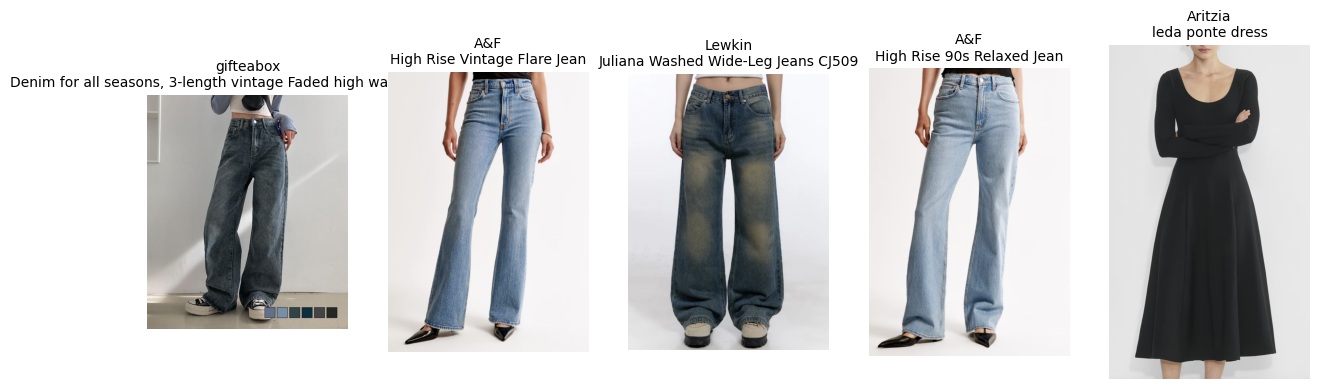


🔹 Recommendations for User: matt


🔹 Top-5 Recommendations for User: matt



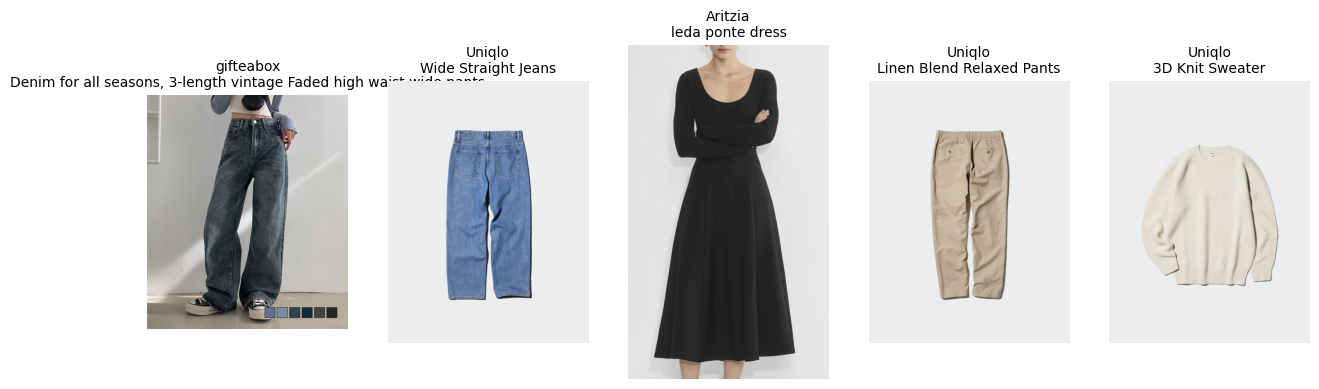


🔹 Recommendations for User: megan


🔹 Top-5 Recommendations for User: megan



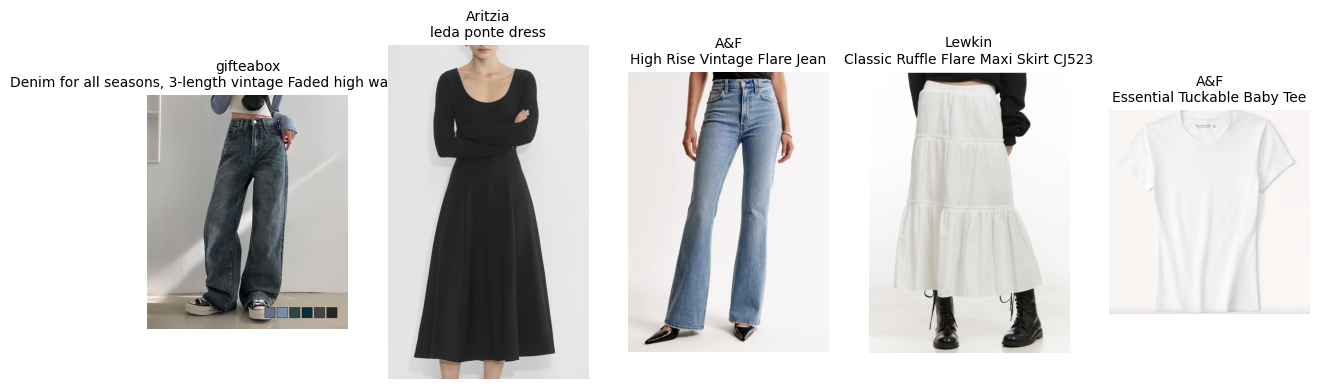


🔹 Recommendations for User: vivian


🔹 Top-5 Recommendations for User: vivian



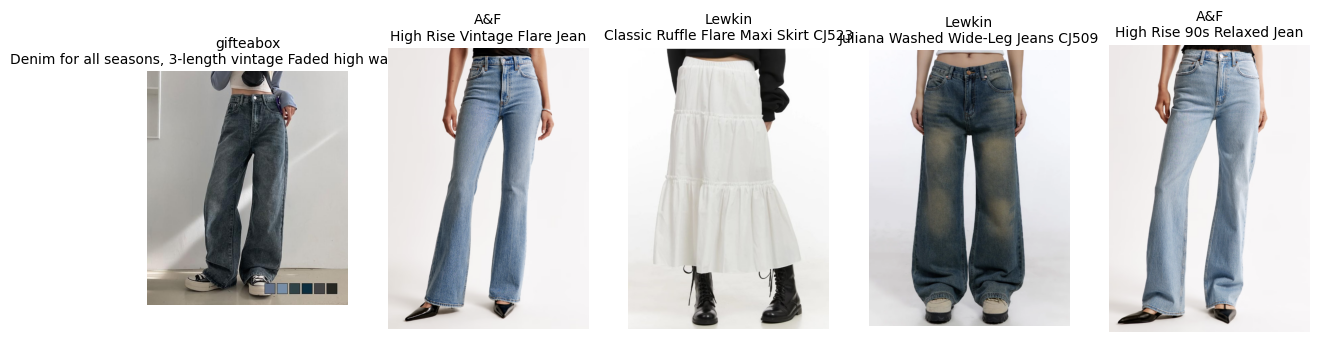

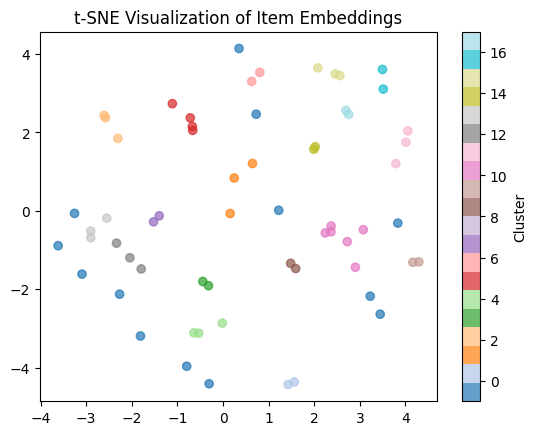

C:\Users\megdy\AppData\Local\Temp\ipykernel_32956\3707276361.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["cluster"].value_counts().index, y=df["cluster"].value_counts().values, palette="viridis")


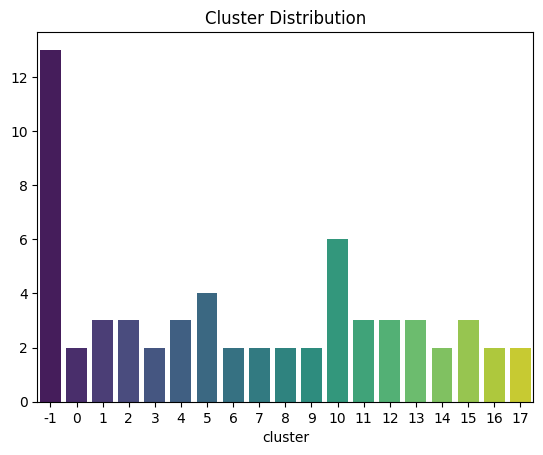

In [105]:
# Run & Display Results
for user_id in user_item_dict.keys():
    print(f"\n🔹 Recommendations for User: {user_id}\n")
    show_recommendations(user_id, top_k=5)  # Adjust top_k as needed
visualize_embeddings()
plot_cluster_distribution()
